In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patches as patches
import random
from breakout_env import *
from wait import *
import tensorflow as tf

In [2]:
tf.flags.DEFINE_boolean("restore", False, "Print scores performance")
FLAGS = tf.flags.FLAGS

env = breakout_environment(nx = 5, ny = 8, nb = 3, nt = 1, nf = 2)

# DQN description
I experimented with 3 different model stuctures:

1. Two CNN layers with f1_shape=[3x2x2x25] and f2_shape=[2x1x25x50] plus two fully connected layers fc1_shape=[500x100] and fc2_shape=[100x3]
2. One CNN layer with f1_shape=[2x1x2x80] plus two fully connected layers fc1_shape=[2800x150] and fc2_shape=[150x3]
3. Two fully connected layers fc1_shape=[80x80] and fc2_shape=[80x3]

The latter model exhibited the most stable performance, most frequently achieving the maximum reward of 15 during the test game. The reason can be that the input state has a very small size and convolutions are not much helpful in such cases.

In [3]:
class DQN:
    def __init__(self, env):
        # state size [ny, nx, nf]
        self.s = tf.placeholder(tf.float32, shape=[None, env.ny, env.nx, env.nf])
        self.a = tf.placeholder(tf.int32, shape=[None])
        self.batch_size = tf.placeholder(tf.int32, shape=[])
        self.bootstraped = tf.placeholder(tf.float32, shape=[None])
        self.ch1 = 80
        self.env = env
        # network parameters
        W_fc1 = tf.Variable(tf.truncated_normal([env.nx*env.ny*env.nf, self.ch1],\
                                                stddev=0.1))
        b_fc1 = tf.Variable(tf.constant(0.1, shape=[self.ch1]))
        W_fc2 = tf.Variable(tf.truncated_normal([self.ch1, env.na], stddev=0.1))
        b_fc2 = tf.Variable(tf.constant(0.1, shape=[env.na]))
        # Q network 
        h_flat = tf.reshape(self.s, [self.batch_size, -1])
        fc1 = tf.matmul(h_flat, W_fc1) + b_fc1
        self.q = tf.matmul(tf.nn.relu(fc1), W_fc2) + b_fc2
        # find Q values for particular actions
        action_one_hot = tf.one_hot(self.a, env.na, 1.0, 0.0, name='action_one_hot')
        self.q_a = tf.reduce_sum(self.q * action_one_hot, reduction_indices=1, \
                                                                     name='q_acted')

        self.optim = tf.train.RMSPropOptimizer(0.0002, momentum=0.95, epsilon=0.01) 
        self.theta = [W_fc1, b_fc1, W_fc2, b_fc2]
        self.target_init()
        # minimize MSE between bootstraped value of target network and 
        # apporximated value of behaviour network
        losses = tf.squared_difference(self.bootstraped, self.q_a)
        self.loss = tf.reduce_mean(losses)
        self.train_step = self.optim.minimize(self.loss)

    def copy_parameters(self):
        for i in range(len(self.theta)):
            self.theta_[i].assign(self.theta[i]).eval()

    def target_init(self):
        self.theta_ = []
        for param in self.theta:
            self.theta_ += [tf.Variable(tf.truncated_normal(tf.shape(param), stddev=0.1))]
        W_fc1, b_fc1, W_fc2, b_fc2 = self.theta_

        h_flat = tf.reshape(self.s, [self.batch_size, -1])
        fc1 = tf.matmul(h_flat, W_fc1) + b_fc1
        self.q_ = tf.matmul(tf.nn.relu(fc1), W_fc2) + b_fc2
        self.q_max_ = tf.reduce_max(self.q_, axis=1)

    def train_iter(self, s, a, bootstraped):
        loss = self.loss.eval(feed_dict={self.s: s, self.a: a, self.batch_size:\
                                    s.shape[0], self.bootstraped:bootstraped})
        self.train_step.run(feed_dict={self.s: s, self.a: a, self.batch_size:\
                                    s.shape[0], self.bootstraped:bootstraped})
        return loss

    def target_q(self, s):
        return self.q_max_.eval(feed_dict={self.s: s, self.batch_size: s.shape[0]})

    def behav_q(self, s):
        return self.q.eval(feed_dict={self.s: np.expand_dims(s, axis=0), \
                                      self.batch_size: 1})

# Hyperparameters
Were found empirically

In [4]:
max_steps = 200      # max number of steps to run in each episode
gamma = 0.85
batch_size = 30
replay_size = 2000
replay_start = 100
n_episodes = 4500 + replay_start       
target_update = 100

class epsilon_profile: pass
epsilon_profile = epsilon_profile()
epsilon_profile.init = 1.    # initial epsilon in e-greedy
epsilon_profile.final = 0.1   # final epsilon in e-greedy
epsilon_profile.dec_episode = 1. / n_episodes  # amount of decrement in each episode
epsilon_profile.dec_step = 0.   # amount of decrement in each step

In [5]:
sess = tf.InteractiveSession()

In [6]:
agent = DQN(env)
tf.group(tf.global_variables_initializer(), tf.local_variables_initializer()).run()
# copy behaviour network parameters to target network
agent.copy_parameters()
saver = tf.train.Saver()

In [7]:
epsilon = epsilon_profile.init
losses, ep_r, ep_st, replay = [], [], [], []

In [8]:
if not FLAGS.restore:
    for episode in range(n_episodes):
        env_s = env.reset()
        env_done = 0
        ep_r += [0]
        for t in range(max_steps):
            if np.random.rand() < epsilon:
                env_a = np.random.randint(env.na) 
            else:
                env_q = agent.behav_q(env_s)
                env_a = np.random.choice(np.where(env_q[0] == np.max(env_q))[0])

            env_sn, env_r, env_done, _,_,_,_,_,_,_,_ = env.run(env_a - 1)             
            if len(replay) == replay_size:
                replay.pop(0)
            ep_r[-1] += env_r
            replay += [(env_s, env_a, env_r, env_sn, env_done)] 
            
            if len(replay) >= replay_start:
                samples = random.sample(replay, batch_size)
                s, a, r, sn, done = map(np.array, zip(*samples))
                # training behaviour network parameters by Q learning
                q_max_ = agent.target_q(sn)
                bootstraped = r + (1. - done)*gamma*q_max_
                loss = agent.train_iter(s, a, bootstraped)
                losses += [loss]
                epsilon = max(epsilon - epsilon_profile.dec_step, epsilon_profile.final) 
            if env_done == 1:
                ep_st += [t]
                break
            env_s = env_sn
            
        if env_done != 1:
            ep_st += [max_steps]
        
        if len(replay) >= replay_start:
            if episode % target_update == 0:
                # copy behaviour network parameters to target network
                agent.copy_parameters()
            print_rate =50
            if episode % print_rate == 0:
                print('loss = %5.4f  av_r = %2.4f  r = %2d  av_steps = %3.1f  episode = %d  epsilon=%1.2f'\
                                    % (loss, np.mean(ep_r[:print_rate]), ep_r[-1],\
                                    np.mean(ep_st[:print_rate]), episode, epsilon))
                ep_r, ep_st = [], []
            epsilon = max(epsilon - epsilon_profile.dec_episode, epsilon_profile.final)

    save_path = saver.save(sess, "./breakout.ckpt")
else:
    saver.restore(sess, "./breakout.ckpt")

loss = 0.0723  av_r = 0.7000  r =  2  av_steps = 6.4  episode = 50  epsilon=0.99
loss = 0.0551  av_r = 1.0200  r =  1  av_steps = 8.6  episode = 100  epsilon=0.98
loss = 0.0467  av_r = 0.8200  r =  0  av_steps = 7.2  episode = 150  epsilon=0.97
loss = 0.0141  av_r = 0.8800  r =  1  av_steps = 7.4  episode = 200  epsilon=0.96
loss = 0.0444  av_r = 0.8200  r =  0  av_steps = 7.1  episode = 250  epsilon=0.95
loss = 0.0223  av_r = 0.7800  r =  2  av_steps = 7.0  episode = 300  epsilon=0.94
loss = 0.0378  av_r = 1.0000  r =  3  av_steps = 8.1  episode = 350  epsilon=0.93
loss = 0.0662  av_r = 1.2200  r =  1  av_steps = 10.0  episode = 400  epsilon=0.91
loss = 0.0254  av_r = 1.0200  r =  0  av_steps = 8.4  episode = 450  epsilon=0.90
loss = 0.0117  av_r = 1.2200  r =  2  av_steps = 9.8  episode = 500  epsilon=0.89
loss = 0.0410  av_r = 0.8800  r =  1  av_steps = 7.4  episode = 550  epsilon=0.88
loss = 0.0168  av_r = 0.7000  r =  1  av_steps = 6.5  episode = 600  epsilon=0.87
loss = 0.0149  a

In [9]:
print("\nTesting \n")
env_s = env.reset()
ep_r = []
env_done = 0
for t in range(max_steps):
    env_q = agent.behav_q(env_s)
    env_a = np.random.choice(np.where(env_q[0] == np.max(env_q))[0])
    env_sn, env_r, env_done, _,_,_,_,_,_,_,_ = env.run(env_a - 1)  
    ep_r += [env_r]
    if env_done == 1:
        break
    env_s = env_sn

print("obtained reward = %2d in %3d steps" % (np.sum(ep_r), len(ep_r)))


Testing 

obtained reward = 15 in 115 steps


# Screentshots from the game

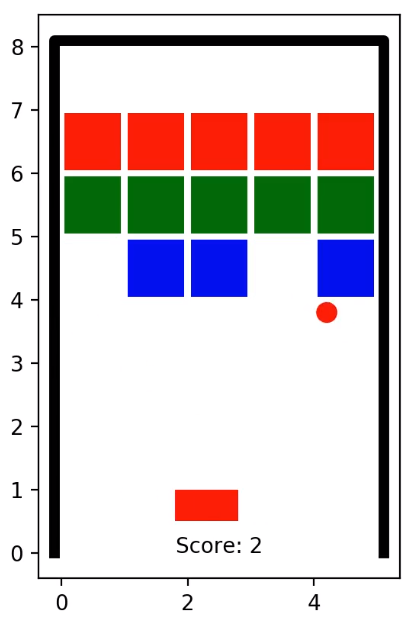

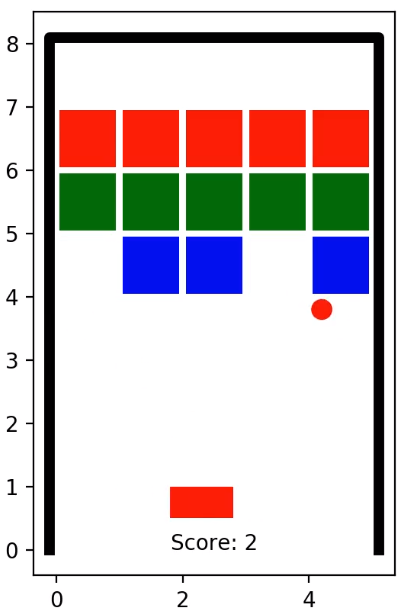

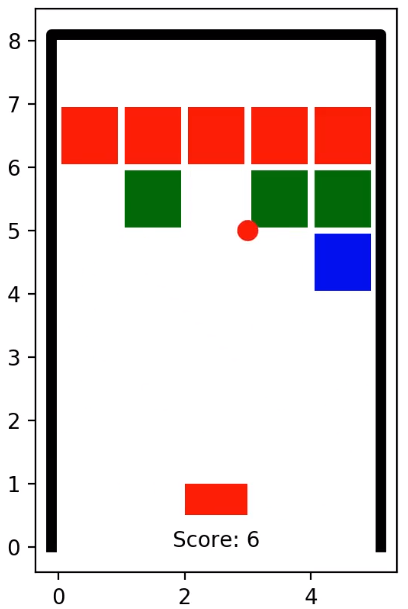

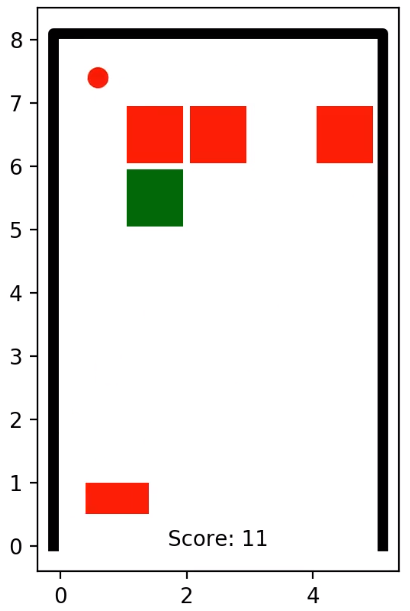

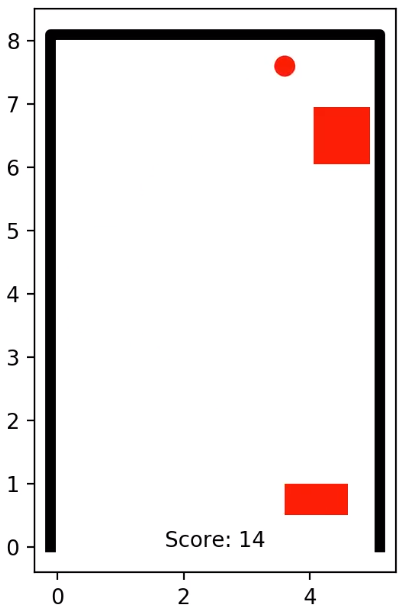

In [26]:
from IPython.display import Image
from IPython.display import display
res = []
#for ima in ['br1.png','br2.png','br3.png','br4.png','br5.png']:
x1 = Image(filename='br1.png', width=250) 
x2 = Image(filename='br2.png', width=250) 
x3 = Image(filename='br3.png', width=250) 
x4 = Image(filename='br4.png', width=250) 
x5 = Image(filename='br5.png', width=250) 
display(x1,x2,x3,x4,x5)

# Breakout Animation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patches as patches
import tensorflow as tf


class breakout_animation(animation.TimedAnimation):
    def __init__(self, env, max_steps, frames_per_step = 5):
        self.env = env
        self.agent = self.initialize_agent()
        self.max_steps = max_steps

        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.set_aspect('equal')
        self.objs = []

        # boundary
        w = 0.1
        ax.plot([-w,-w,env.nx+w,env.nx+w],[0,env.ny+w,env.ny+w,0],'k-',linewidth=5)

        # bricks
        wb = 0.05
        self.bricks = []
        self.brick_colors = [['red'], ['blue','red'], ['blue','green','red'], \
                ['blue','green','yellow','red'], ['blue','green','yellow',\
                'orange','red'], ['purple','blue','green','yellow','brown',\
                'orange','red'], ['purple','blue','green','yellow','brown',\
                                                              'orange','red']]    
        for y in range(self.env.nb):
            b = []
            yp = y + (self.env.ny - self.env.nt - self.env.nb)
            for x in range(self.env.nx):
                b.append(patches.Rectangle((x + wb, yp + wb), 1-2*wb, 1-2*wb, \
                edgecolor='none', facecolor=self.brick_colors[self.env.nb-1][y]))
                ax.add_patch(b[x])
                self.objs.append(b[x])
            self.bricks.append(b)
 
        # ball
        self.ball = patches.Circle(env.get_ball_pos(0.), radius = 0.15, color = 'red')
        ax.add_patch(self.ball)
        self.objs.append(self.ball)

        # score text
        self.text = ax.text(0.5 * env.nx, 0, '', ha='center')
        self.objs.append(self.text)

        # game over text
        self.gameover_text = ax.text(0.5 * env.nx, 0.5 * env.ny, '', ha='center')
        self.objs.append(self.gameover_text)

        self.frames_per_step = frames_per_step
        self.total_frames = self.frames_per_step * self.max_steps

        # paddle
        self.paddle = patches.Rectangle((env.p, 0.5), 1, 0.5, edgecolor='none', facecolor='red')
        ax.add_patch(self.paddle)

        # for early termination of animation
        self.iter_objs = []
        self.iter_obj_cnt = 0

        # interval = 50msec
        animation.TimedAnimation.__init__(self, fig, interval=50, repeat=False, blit=False)

    def initialize_agent(self):
        sess = tf.InteractiveSession()
        agent = DQN(env)
        tf.group(tf.global_variables_initializer(), tf.local_variables_initializer()).run()
        agent.copy_parameters()
        saver = tf.train.Saver()
        saver.restore(sess, "./breakout.ckpt")
        return agent

    def _draw_frame(self, k):
        if self.terminal:
            return
        if k == 0:
            self.iter_obj_cnt -= 1
        if k % self.frames_per_step == 0:
            # take action to maximize Q value
            env_q = self.agent.behav_q(self.env.s)
            env_a = np.random.choice(np.where(env_q[0] == np.max(env_q))[0])
            self.a = env_a - 1
            self.p = self.env.p
            self.pn = min(max(self.p + self.a, 0), self.env.nx - 1)

        t = (k % self.frames_per_step) * 1. / self.frames_per_step
        self.ball.center = self.env.get_ball_pos(t)
        self.paddle.set_x(t * self.pn + (1-t) * self.p)

        if k % self.frames_per_step == self.frames_per_step - 1:
            sn, reward, terminal, p0, p, bx0, by0, vx0, vy0, rx, ry = \
                                                    self.env.run(self.a)
            self.sum_reward += reward
            if reward > 0.:
                self.bricks[ry][rx].set_facecolor('none')
                self.text.set_text('Score: %d' % self.sum_reward)
            if terminal:
                self.terminal = terminal
                self.gameover_text.set_text('Game Over')
                for _ in range(self.total_frames - k - 1):
                    self.iter_objs[self.iter_obj_cnt].next()     

        self._drawn_artists = self.objs

    def new_frame_seq(self):
        iter_obj = iter(range(self.total_frames))
        self.iter_objs.append(iter_obj)
        self.iter_obj_cnt += 1
        return iter_obj

    def _init_draw(self):
        _ = self.env.reset()
        self.sum_reward = 0.
        self.p = self.env.p    # current paddle position
        self.pn = self.p       # next paddle position
        self.a = 0             # action
        self.terminal = 0

        for y in range(self.env.nb):
            for x in range(self.env.nx):
                self.bricks[y][x].set_facecolor(self.brick_colors[self.env.nb-1][y])

        self.ball.center = self.env.get_ball_pos(0.)
        self.paddle.set_x(self.p)

        self.text.set_text('Score: 0')
        self.gameover_text.set_text('')


class DQN:
    def __init__(self, env):
        # state size [ny, nx, nf]
        self.s = tf.placeholder(tf.float32, shape=[None, env.ny, env.nx, env.nf])
        self.a = tf.placeholder(tf.int32, shape=[None])
        self.batch_size = tf.placeholder(tf.int32, shape=[])
        self.bootstraped = tf.placeholder(tf.float32, shape=[None])
        self.ch1 = 80
        self.env = env

        W_fc1 = tf.Variable(tf.truncated_normal([env.nx*env.ny*env.nf, self.ch1], \
                                                stddev=0.1))
        b_fc1 = tf.Variable(tf.constant(0.1, shape=[self.ch1]))
        W_fc2 = tf.Variable(tf.truncated_normal([self.ch1, env.na], stddev=0.1))
        b_fc2 = tf.Variable(tf.constant(0.1, shape=[env.na]))

        h_flat = tf.reshape(self.s, [self.batch_size, -1])
        fc1 = tf.matmul(h_flat, W_fc1) + b_fc1
        self.q = tf.matmul(tf.nn.relu(fc1), W_fc2) + b_fc2        
        action_one_hot = tf.one_hot(self.a, env.na, 1.0, 0.0, name='action_one_hot')
        self.q_a = tf.reduce_sum(self.q * action_one_hot, reduction_indices=1, name='q_acted')

        self.optim = tf.train.RMSPropOptimizer(0.0002, momentum=0.95, epsilon=0.01) 
        self.theta = [W_fc1, b_fc1, W_fc2, b_fc2]
        self.target_init()

        losses = tf.squared_difference(self.bootstraped, self.q_a)
        self.loss = tf.reduce_mean(losses)
        self.train_step = self.optim.minimize(self.loss)

    def copy_parameters(self):
        for i in range(len(self.theta)):
            self.theta_[i].assign(self.theta[i]).eval()

    def target_init(self):
        self.theta_ = []
        for param in self.theta:
            self.theta_ += [tf.Variable(tf.truncated_normal(tf.shape(param), \
                                                            stddev=0.1))]
        W_fc1, b_fc1, W_fc2, b_fc2 = self.theta_

        h_flat = tf.reshape(self.s, [self.batch_size, -1])
        fc1 = tf.matmul(h_flat, W_fc1) + b_fc1
        self.q_ = tf.matmul(tf.nn.relu(fc1), W_fc2) + b_fc2
        self.q_max_ = tf.reduce_max(self.q_, axis=1)

    def train_iter(self, s, a, bootstraped):
        loss = self.loss.eval(feed_dict={self.s: s, self.a: a, self.batch_size: \
                                        s.shape[0],self.bootstraped:bootstraped})
        self.train_step.run(feed_dict={self.s: s, self.a: a, self.batch_size: \
                                       s.shape[0], self.bootstraped:bootstraped})
        return loss

    def target_q(self, s):
        return self.q_max_.eval(feed_dict={self.s: s, self.batch_size: s.shape[0]})

    def behav_q(self, s):
        return self.q.eval(feed_dict={self.s: np.expand_dims(s, axis=0), \
                                      self.batch_size: 1})



from breakout_env import *
from wait import *

env = breakout_environment(nx = 5, ny = 8, nb = 3, nt = 1, nf = 2)
ani = breakout_animation(env, 200)
#ani.save('breakout.mp4', dpi=200)
plt.show(block=False)
wait('Press enter to quit')
